# Setup

## 1.1 Installing Dependencies

In [1]:
!pip3 install tensorflow opencv-python matplotlib

In [2]:
# tensorflow gpu installation failure

!pip3 install tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


## 1.2 Importing Dependencies

In [148]:
#Importing standard dependenicies

import numpy as np

#importing open cv
import cv2

#The OS module provides functions for interacting with the OS
import os

# For generating random data
import random

# For effectively visualizing an image (plt.imshow())
from matplotlib import pyplot as plt

## 1.3 Import GPU Dependencies

In [4]:
#Importing TensorFlow dependenicies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.4 Creating folder structures

In [12]:
#Setting up paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [13]:
#making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collecting +ve images and anchor images

In [14]:
# Collecting images that will enable us train our model

## 2.1 Collecting -ve images from LFW

In [15]:
#uncompress LFW dataset
!tar -xf lfw.tar

In [18]:
#move LFW images to 'data/negative'

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        
        os.replace(EX_PATH, NEW_PATH)

In [19]:
#testing
os.listdir('data')

['positive', 'negative', 'anchor']

## 2.2 Collect +ve & anchor classes

In [20]:
# Image size should be 250px by 250 px to sync with the LFW dataset
#Place the webcam approximately 0.9 metres from the student while
# taking the images

In [21]:
#Importing UUID library to allocate unique names to each of the images
# UUID - Universally Unique Identifier
import uuid

In [28]:
#Establish connection to my webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    #cap.read is for reading the capture
    ret, frame = cap.read()
    
    #reduce capture frame to 250px X 250px
    frame = frame[200:200+250, 550:550+250, :]
    
    #Collecting anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        #create a unique name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        
    #Collecting positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
         #create a unique name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        
    #render image back to screen
    cv2.imshow('Strathmore University Secure Access System', frame)
    
    #Breaking procedurally
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#Release the webcam
cap.release()

#close the image show frame
cv2.destroyAllWindows()

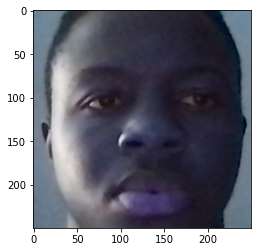

In [29]:
#Place the webcam approximately 0.9 metres from the student while
# taking the images
plt.imshow(frame)

# Load & Preprocess Images

## 3.1 Get Image Directories

In [30]:
#Grab only 300 images within a specific directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [31]:
ANC_PATH+'/*jpg/'

'data/anchor/*jpg/'

In [32]:
dir_test = anchor.as_numpy_iterator()

In [33]:
print(dir_test.next())

b'data/anchor/e36a6b78-04f8-11ed-a1be-acde48001122.jpg'


## 3.2 Preprocessing - Scale & Resize

In [34]:
#load image, resize, and scale it

In [35]:
#preprocess function
def preprocess (file_path):
    # Read in image from file path (in byte form)
    byte_img = tf.io.read_file(file_path)
    #load in image
    img = tf.io.decode_jpeg(byte_img, channels=3)
    
    # Preprocessing steps - resizing the image to 100px X 100px X 3 channels
    # Why 100 X 100? (it's based on the Siames model doc)
    img = tf.image.resize(img, (100,100))
    #Scale image to be btw 0 and 1
    img = img/255.0
    #return img
    return img

In [36]:
img = preprocess('data/negative/Clare_Short_0001.jpg')

In [37]:
img.numpy().max()

0.99852943

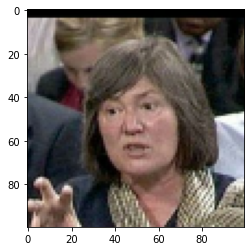

In [38]:
#display image after scaling
plt.imshow(img)

In [39]:
!pip3 install tensorflow_datasets

In [40]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [41]:
anchor.map(preprocess)

<MapDataset element_spec=TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None)>

## 3.3 Create a labelled Dataset

In [42]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [43]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [44]:
samples = data.as_numpy_iterator()

In [45]:
example = samples.next()

In [46]:
example

(b'data/anchor/d8dde540-04f8-11ed-a1be-acde48001122.jpg',
 b'data/positive/38d71f62-04f8-11ed-a1be-acde48001122.jpg',
 1.0)

## 3.4 Build Train & Test Partition

In [47]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [48]:
res = preprocess_twin(*example)

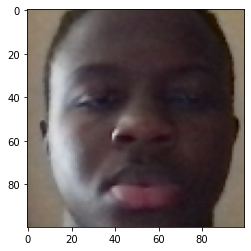

In [49]:
plt.imshow(res[0])

In [50]:
res[2]

1.0

In [51]:
#build a dataloader pipeline

#map
data = data.map(preprocess_twin)
#cache images
data = data.cache()
#shuffle images for approprite training
data = data.shuffle(buffer_size=1024)

In [52]:
sampless = data.as_numpy_iterator()

In [53]:
len(sampless.next())

3

In [54]:
samp = sampless.next()

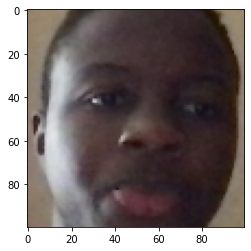

In [55]:
plt.imshow(samp[1])

In [56]:
samp[2]

1.0

In [57]:
#Training partition

#take 70% of the dataset for training and round it
train_data = data.take(round(len(data)*.7))
#pass the data in batches of 16 units
train_data = train_data.batch(16)
#prefetch preprocesses the next data in order to reduce bottleneck in the model
train_data = train_data.prefetch(8)

In [58]:
train_samples = train_data.as_numpy_iterator()

In [59]:
train_sample = train_samples.next()

In [60]:
len(train_sample[0])

16

In [61]:
#Testing partition

test_data = data.skip(round(len(data)*.7))

#grab the remaining 30% for testing purposes
test_data = test_data.take(round(len(data)*.3))

test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [62]:
def make_embedding():
    #defining the input layer (with reference to the Siamese paper)
    inp = Input(shape=(100,100,3), name='input_image')
    
    #FIRST BLOCK
    #convolution layer plus Relu activation (64 units/filters/channels)
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    #max pooling layer
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #SECOND BLOCK
    #(128 units with relu activation)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #THIRD BLOCK
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #FINAL EMBEDDING BLOCK
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    #flatten to a single dimension
    f1 = Flatten()(c4)
    
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [63]:
embedding = make_embedding()

In [64]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [65]:
#Create a Siamese class L1Dist for the neural network layer
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        #inheritance
        super().__init__()
    
    #checking the similarity btw respective anchor image 
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [66]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [67]:
def make_siamese_model():
    
    #Handle inputs
    
    #Anchor image in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    #Combine siamese deistance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiamesNetwork')
    

In [68]:
siamese_model = make_siamese_model()

In [69]:
siamese_model.summary()

Model: "SiamesNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][0

# Training

## 5.1 Setup Loss and Optimizer

In [70]:
#Loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [71]:
#Using the Adam optimizer

#1e-4 is the learning rate of #0.001
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [72]:
#directory to save all our dir checkpoints
checkpoint_dir = './training_checkpoints'
#ckpt prefix for all checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [73]:
test_batch = train_data.as_numpy_iterator()

In [74]:
batch_1 = test_batch.next()

In [75]:
X = batch_1[:2]

In [76]:
y = batch_1[2]

In [77]:
y

array([1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [78]:
tf.losses.BinaryCrossentropy??

In [89]:
#Training on one batch of data

#Why use a tf.function manner?
# It compiles a function into a callable TensorFlow graph
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss
    

## 5.4 Build Training Loop

In [83]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [84]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [87]:
EPOCHS = 50

In [90]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 117s 4s/step
0.35238343 0.39908257 1.0

 Epoch 2/50
27/27 [==============================] - 121s 4s/step
0.10274796 0.95566505 1.0

 Epoch 3/50
27/27 [==============================] - 121s 4s/step
0.0031463874 0.9949495 1.0

 Epoch 4/50
27/27 [==============================] - 122s 5s/step
0.00028001243 1.0 1.0

 Epoch 5/50
27/27 [==============================] - 123s 5s/step
2.2500833e-06 1.0 1.0

 Epoch 6/50
1/1 [==============================] - 1s 778ms/step


27/27 [==============================] - 123s 5s/step
1.8016131e-05 1.0 1.0

 Epoch 7/50
27/27 [==============================] - 127s 5s/step
1.5348224e-06 1.0 1.0

 Epoch 8/50
27/27 [==============================] - 130s 5s/step
8.165881e-06 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 127s 5s/step
3.0100434e-06 1.0 1.0

 Epoch 10/50
27/27 [==============================] - 129s 5s/step
0.000107072505 1.0 1.0

 Epoch 11/50
1/1 [==============================] - 1s 785ms/step


27/27 [==============================] - 120s 4s/step
9.685764e-07 1.0 1.0

 Epoch 12/50
27/27 [==============================] - 119s 4s/step
2.275505e-05 1.0 1.0

 Epoch 13/50
27/27 [==============================] - 118s 4s/step
0.0002066061 1.0 1.0

 Epoch 14/50
27/27 [==============================] - 119s 4s/step
9.834783e-07 1.0 1.0

 Epoch 15/50
27/27 [==============================] - 117s 4s/step
1.1190903e-05 1.0 1.0

 Epoch 16/50
27/27 [==============================] - 117s 4s/step


4.2468573e-06 1.0 1.0

 Epoch 17/50
27/27 [==============================] - 126s 5s/step
4.4703487e-08 1.0 1.0

 Epoch 18/50
27/27 [==============================] - 130s 5s/step
5.2154115e-07 1.0 1.0

 Epoch 19/50
27/27 [==============================] - 123s 5s/step
5.960465e-08 1.0 1.0

 Epoch 20/50
27/27 [==============================] - 121s 4s/step
4.0233166e-07 1.0 1.0

 Epoch 21/50
27/27 [==============================] - 123s 5s/step
5.811457e-07 1.0 1.0

 Epoch 22/50
1/1 [==============================] - 1s 792ms/step


27/27 [==============================] - 126s 5s/step
7.450581e-08 1.0 1.0

 Epoch 23/50
27/27 [==============================] - 133s 5s/step
1.1027091e-05 1.0 1.0

 Epoch 24/50
27/27 [==============================] - 129s 5s/step
2.533198e-07 1.0 1.0

 Epoch 25/50
27/27 [==============================] - 130s 5s/step
1.4603181e-06 1.0 1.0

 Epoch 26/50
27/27 [==============================] - 129s 5s/step
9.216577e-05 1.0 1.0

 Epoch 27/50
1/1 [==============================] - 1s 830ms/step


27/27 [==============================] - 127s 5s/step
4.6193642e-07 1.0 1.0

 Epoch 28/50
27/27 [==============================] - 130s 5s/step
7.599598e-07 1.0 1.0

 Epoch 29/50
27/27 [==============================] - 125s 5s/step
2.3096852e-06 1.0 1.0

 Epoch 30/50
27/27 [==============================] - 122s 5s/step
0.0 1.0 1.0

 Epoch 31/50
27/27 [==============================] - 121s 5s/step
5.960465e-08 1.0 1.0

 Epoch 32/50
27/27 [==============================] - 125s 5s/step
8.940699e-08 1.0 1.0

 Epoch 33/50
1/1 [==============================] - 1s 734ms/step


27/27 [==============================] - 117s 4s/step
1.4901163e-08 1.0 1.0

 Epoch 34/50
27/27 [==============================] - 120s 4s/step
8.19565e-07 1.0 1.0

 Epoch 35/50
27/27 [==============================] - 127s 5s/step
0.0 1.0 1.0

 Epoch 36/50
27/27 [==============================] - 120s 4s/step
4.47035e-07 1.0 1.0

 Epoch 37/50
27/27 [==============================] - 123s 5s/step
3.716487e-05 1.0 1.0

 Epoch 38/50
1/1 [==============================] - 1s 804ms/step


27/27 [==============================] - 127s 5s/step
0.0 1.0 1.0

 Epoch 39/50
27/27 [==============================] - 127s 5s/step
5.4687857e-06 1.0 1.0

 Epoch 40/50
27/27 [==============================] - 126s 5s/step
2.2351752e-07 1.0 1.0

 Epoch 41/50
27/27 [==============================] - 121s 4s/step
1.6540315e-06 1.0 1.0

 Epoch 42/50
27/27 [==============================] - 125s 5s/step
1.0430815e-07 1.0 1.0

 Epoch 43/50
1/1 [==============================] - 1s 774ms/step


27/27 [==============================] - 124s 5s/step
1.1920932e-07 1.0 1.0

 Epoch 44/50
27/27 [==============================] - 129s 5s/step
0.0 1.0 1.0

 Epoch 45/50
27/27 [==============================] - 127s 5s/step
1.3411048e-07 1.0 1.0

 Epoch 46/50
27/27 [==============================] - 130s 5s/step
2.847774e-05 1.0 1.0

 Epoch 47/50
27/27 [==============================] - 131s 5s/step
5.960465e-08 1.0 1.0

 Epoch 48/50
27/27 [==============================] - 129s 5s/step
2.9802326e-08 1.0 1.0

 Epoch 49/50
1/1 [==============================] - 1s 740ms/step


27/27 [==============================] - 117s 4s/step
0.0 1.0 1.0

 Epoch 50/50
27/27 [==============================] - 118s 4s/step
7.2271678e-06 1.0 1.0


## Evaluate Model

## 6.1 Import Metrics

In [91]:
# Import metric calculation
from tensorflow.keras.metrics import Precision, Recall

In [92]:
# Get test data

#convert tensorflow dataset into a numpy iterator
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

## 6.2 Make Predictions

In [93]:
# Making predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 694ms/step


array([[2.38673814e-09],
       [1.66385528e-09],
       [1.00000000e+00],
       [9.99515777e-08],
       [9.99999881e-01],
       [2.94792940e-10],
       [1.00000000e+00],
       [1.01329995e-07],
       [3.34463834e-09],
       [1.52735584e-08],
       [1.13795373e-09],
       [9.99915242e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.31703365e-09]], dtype=float32)

In [94]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]

In [95]:
y_true

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

## 6.3 Calculation Metrics

In [96]:
#Creating a metric object
m = Recall()
#Calculate the recall value
m.update_state(y_true, y_hat)

# Return Recall() result
m.result().numpy()

1.0

In [97]:
#Creating a metric object
m = Precision()
#Calculate the precision value
m.update_state(y_true, y_hat)

# Return Precision() result
m.result().numpy()

1.0

## 6.4 Lee's Results

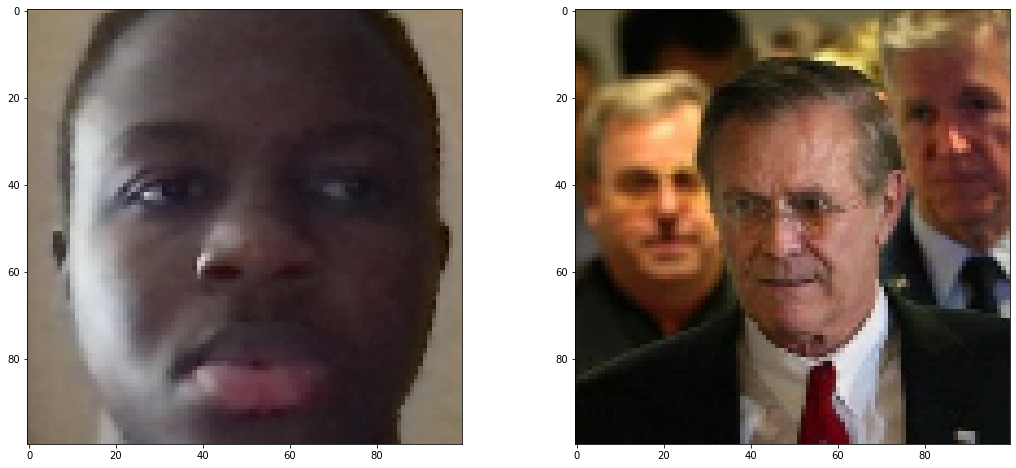

In [98]:
#Compare the results with the arrays in section 2.2

#setting image/plot size
plt.figure(figsize=(18,8))
#Setting first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])

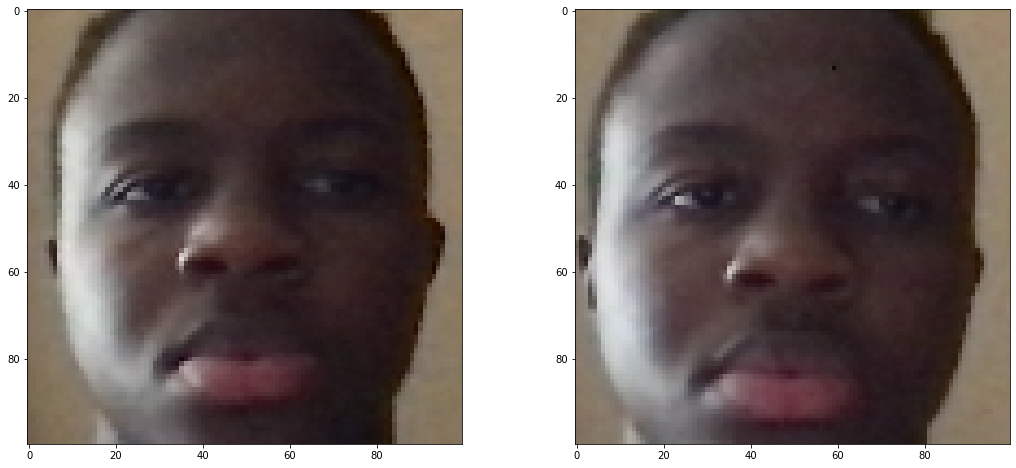

In [100]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])

## 7. Save Model

In [118]:
# Save weights
siamese_model.save('siamesemodelone.h5')

In [119]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelone.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [131]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 687ms/step


array([[2.38673814e-09],
       [1.66385528e-09],
       [1.00000000e+00],
       [9.99515777e-08],
       [9.99999881e-01],
       [2.94792940e-10],
       [1.00000000e+00],
       [1.01329995e-07],
       [3.34463834e-09],
       [1.52735584e-08],
       [1.13795373e-09],
       [9.99915242e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.31703365e-09]], dtype=float32)

In [132]:
# View model summary
siamese_model.summary()

Model: "SiamesNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][0

## 8. Real Time Test

In [122]:
#Access webcam using Open CV
#Retrieve Input Image
#Use the image and verify against 50 images
#One verification cycle is an average of 50 different verifications
#Pass the input image and test images to the neural network
#Set a verificaiton threshold
#Calculate the detection threshold - a metric above which a prediction is considered positive

## 8.1 Verification Function

In [142]:
os.listdir(os.path.join('application_data', 'verification_images'))

['b0ee00e2-04f8-11ed-a1be-acde48001122.jpg']

In [143]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [138]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/b0ee00e2-04f8-11ed-a1be-acde48001122.jpg


In [144]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [157]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

OpenCV: out device of bound (0-0): 4
OpenCV: camera failed to properly initialize!


In [152]:
results

[array([[1.]], dtype=float32)]

In [114]:
from pathlib import Path
import imghdr

data_dir = "/Users/leesangoroh/Desktop/JN/IS Project/data"
image_extensions = [".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
       # print('accepted')
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")